In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv', thousands=',')
training_set = dataset_train[['Open', 'High', 'Low', 'Close']].values.astype(float)

print(dataset_train.head())
print(training_set)

       Date    Open    High     Low   Close    Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7380500
1  1/4/2012  331.27  333.87  329.08  666.45   5749400
2  1/5/2012  329.83  330.75  326.89  657.21   6590300
3  1/6/2012  328.34  328.77  323.68  648.24   5405900
4  1/9/2012  322.04  322.29  309.46  620.76  11688800
[[325.25 332.83 324.97 663.59]
 [331.27 333.87 329.08 666.45]
 [329.83 330.75 326.89 657.21]
 ...
 [793.7  794.23 783.2  785.05]
 [783.33 785.93 778.92 782.79]
 [782.75 782.78 770.41 771.82]]


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

X_train, y_train = [], []
lookback = 60

for i in range(lookback, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-lookback:i])
    y_train.append(training_set_scaled[i, 0])  # هدف: قیمت Open

X_train, y_train = np.array(X_train), np.array(y_train)


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop


regressor = Sequential()




regressor.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=128, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=128))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

2025-05-26 13:09:24.512123: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 13:09:24.513710: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 13:09:24.538982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 13:09:24.539004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 13:09:24.539670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [9]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


regressor.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stop])


Epoch 1/150
34/34 [==============================] - 1s 43ms/step - loss: 0.0017 - val_loss: 8.3847e-04
Epoch 2/150
34/34 [==============================] - 2s 49ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/150
34/34 [==============================] - 2s 53ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/150
34/34 [==============================] - 2s 49ms/step - loss: 0.0017 - val_loss: 6.7047e-04
Epoch 5/150
34/34 [==============================] - 2s 54ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/150
34/34 [==============================] - 2s 54ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/150
34/34 [==============================] - 2s 44ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8/150
34/34 [==============================] - 2s 47ms/step - loss: 0.0016 - val_loss: 4.6747e-04
Epoch 9/150
34/34 [==============================] - 2s 53ms/step - loss: 0.0014 - val_loss: 4.6663e-04
Epoch 10/150
34/34 [==============================] - 2s 55ms/step - loss: 0.0014 - 

In [10]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv', thousands=',')
real_stock_price = dataset_test[['Open']].values

dataset_total = pd.concat((dataset_train[['Open']], dataset_test[['Open']]), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - lookback:].values

total_data = pd.concat((dataset_train[['Open', 'High', 'Low', 'Close']], dataset_test[['Open', 'High', 'Low', 'Close']]), axis=0)
inputs = total_data[len(total_data) - len(dataset_test) - lookback:].values

inputs_scaled = scaler.transform(inputs)

X_test = []
for i in range(lookback, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-lookback:i])
X_test = np.array(X_test)

predicted_stock_price_scaled = regressor.predict(X_test)

predicted_stock_price = scaler.inverse_transform(
    np.hstack((predicted_stock_price_scaled, 
               np.zeros((predicted_stock_price_scaled.shape[0], 3))))  
)[:, 0]

1/1 [==============================] - 0s 21ms/step


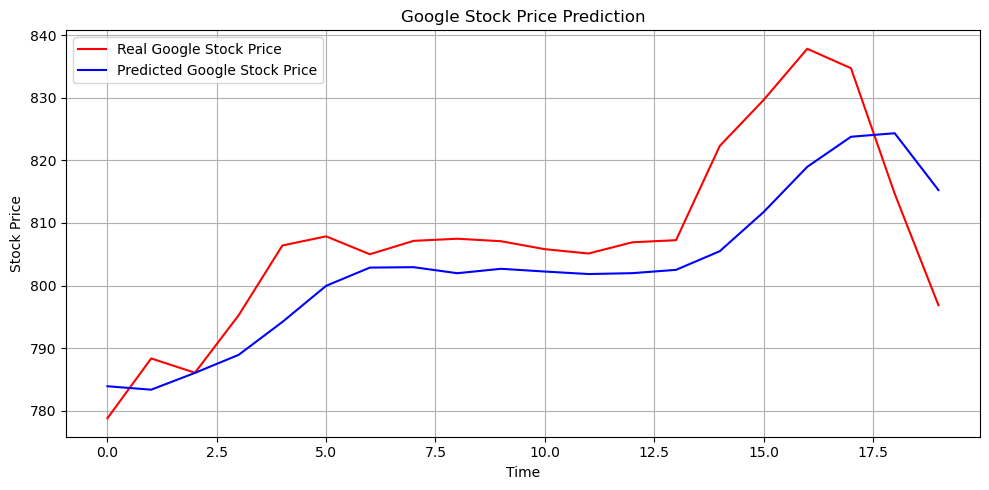

In [11]:
plt.figure(figsize=(10,5))
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# فرض: real_stock_price و predicted_stock_price قبلاً محاسبه شده‌اند

mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 97.7173
Root Mean Squared Error (RMSE): 9.8852
Mean Absolute Error (MAE): 8.0943
R² Score: 0.5504
